# Data collapse

In [1]:
import os
import glob
# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy
import numdifftools as ndt # to comput the Hessian matrix

import mwc_induction_utils as mwc

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Seaborn, useful for graphics
import seaborn as sns

# favorite Seaborn settings for notebooks
rc={'lines.linewidth': 2, 
    'axes.labelsize' : 16, 
    'axes.titlesize' : 18,
    'axes.facecolor' : 'F4F3F6',
    'axes.edgecolor' : '000000',
    'axes.linewidth' : 1.2,
    'xtick.labelsize' : 13,
    'ytick.labelsize' : 13,
    'grid.linestyle' : ':',
    'grid.color' : 'a6a6a6'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)
sns.set_palette("deep", color_codes=True)

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

## The Bohr parameter.

For the *lac* repressor we know that the fold-change in gene expression is given by

\begin{align}
\text{fold-change}(C) = \left( 1 + \frac{2R}{N_{NS}} \cdot p_{act}(C) \cdot e^{-\beta \Delta \epsilon_r} \right)^{-1},
\end{align}

where $R$ is the number of repressors, $N_{NS}$ is the number of non-specific sites to which the repressor can bind, $\Delta \epsilon_r$ is the binding energy of the repressor to the DNA binding site, $\beta$ is the inverse Boltzmann constant times the temperature, and $p_{act}$ is the probability of the repressor being active given a concentration of inducer $C$.

The functional form of this $p_{act}$ is given by the MWC model as

\begin{equation}
p_{act}(C) = \frac{\left( 1 + \frac{C}{K_A} \right)^2}{\left( 1 + \frac{C}{K_A} \right)^2 + e^{-\beta \Delta \epsilon_{ai}}\left( 1 + \frac{C}{K_I} \right)^2},
\end{equation}

where $K_A$ and $K_I$ are the dissociation constants of the repressor in the active and inactive state respectively and $\Delta \epsilon$ is the energetic difference between these two states. For the specific case of the *lac* repressor we have that $K_A \geq K_I$ and $\Delta \epsilon_{ai} \geq 0$.

To isolate the effect of the thermodynamic parameters we can re-write the fold-change equation as a Fermi potential, i.e.

\begin{equation}
\text{fold-change} = \frac{1}{1 + e^{-\beta F(C)}},
\end{equation}

where we have introduced the *Bohr parameter*,

\begin{equation}
F(C) \equiv -k_BT \log \left( \frac{\left( 1 + \frac{C}{K_A} \right)^2}{\left( 1 + \frac{C}{K_A} \right)^2 + e^{-\beta \Delta \epsilon_{ai}}\left( 1 + \frac{C}{K_I} \right)^2} \cdot \frac{2R}{N_{NS}}e^{-\beta \Delta \epsilon_r} \right).
\end{equation}

Let's now go ahead and fit the values of $K_A$ and $K_I$ to the experimetal data. We will assume a value of 4.5 $K_BT$ for the allosteric parameter $\Delta \epsilon_{ai}$ (more on this later).

For this example we will be using the data generated on [`20160805`](https://github.com/RPGroup-PBoC/mwc_induction/blob/master/data/20160805_O2_IPTG_titration_MACSQuant.csv), and [`20160807`](https://github.com/RPGroup-PBoC/mwc_induction/blob/master/data/20160807_O2_IPTG_titration_MACSQuant.csv), so let's go ahead and read the data.

In [2]:
df_05 = pd.read_csv('../../data/20160805_O2_IPTG_titration_MACSQuant.csv',
                   comment='#')
df_07 = pd.read_csv('../../data/20160807_O2_IPTG_titration_MACSQuant.csv',
                   comment='#')

# combine both DataFrames into a single one
df = pd.concat([df_05, df_07], axis=0)

# Now we remove the autofluorescence and delta values
df = df[(df.rbs != 'auto') & (df.rbs != 'delta')]

df.head()

,date,username,operator,binding_energy,rbs,repressors,IPTG_uM,mean_YFP_A,mean_YFP_bgcorr_A,fold_change_A
2,20160805,mrazomej,O2,-13.9,RBS1L,870,0.0,3586.277698,132.792582,0.007538
3,20160805,mrazomej,O2,-13.9,RBS1,610,0.0,3591.757405,138.272290,0.007849
4,20160805,mrazomej,O2,-13.9,RBS1027,130,0.0,3715.043175,261.558059,0.014847
5,20160805,mrazomej,O2,-13.9,RBS446,62,0.0,3985.805741,532.320626,0.030216
6,20160805,mrazomej,O2,-13.9,RBS1147,30,0.0,4376.824276,923.339160,0.052411


Now let's focus on one strain. Let's say RBS1027.

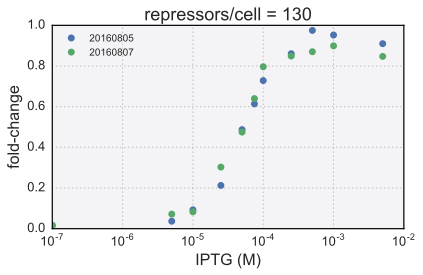

In [3]:
# extract the data
df_1027 = df[df.rbs=='RBS1027']
for date in df_1027.date.unique():
    plt.plot(df_1027[df_1027.date==date].IPTG_uM / 1E6,
             df_1027[df_1027.date==date].fold_change_A, 
             'o', label=str(date), alpha=0.7)
plt.xlabel('IPTG (M)')
plt.ylabel('fold-change')
plt.title('repressors/cell = 130')
plt.xscale('log')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('/Users/razo/Desktop/RBS1027.pdf')

### Non-linear regression on a single strain

Now that we have the data, let's go ahead and perform a non-linear regression on it. The details of the derivation are found [here](https://github.com/RPGroup-PBoC/mwc_induction/blob/master/code/analysis/non_linear_regression.ipynb).

In [4]:
# define dependent and independent variables
dep_var = df_1027.fold_change_A
indep_var = df_1027[['IPTG_uM', 'repressors', 'binding_energy']]

# Initial guess
p0 = np.array([1, 10])

# Extra arguments given as tuple 
args = (indep_var.values, dep_var.values)

# Compute the MAP 
popt, _ = scipy.optimize.leastsq(mwc.resid, p0, args=args)

# Extract the values
ea, ei = popt

# Instantiate a numdifftools Hessian object for the log posterior
hes_fun = ndt.Hessian(mwc.log_post)

# Compute the Hessian at the map
hes = hes_fun(popt, indep_var.values, dep_var.values)

# Compute the covariance matrix
cov = -np.linalg.inv(hes) 

# Get the values for the dissociation constants and their respective error bars
Ka = np.exp(-ea)
Ki = np.exp(-ei)
deltaKa = np.sqrt(cov[0,0]) * Ka
deltaKi = np.sqrt(cov[1,1]) * Ki

# Print results
print("""
The most probable parameters for the MWC model
----------------------------------------------
Ka = {0:.2f} +- {1:0.2f} uM
Ki = {2:.2f} +- {3:0.2f} uM
""".format(Ka, deltaKa, Ki, deltaKi))


The most probable parameters for the MWC model
----------------------------------------------
Ka = 143.84 +- 20.71 uM
Ki = 0.52 +- 0.03 uM



Let's see how well these parameters describe the data.

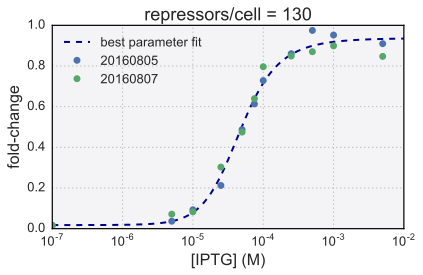

In [5]:
IPTG = np.logspace(-7, -2, 200)
fc_theory = mwc.fold_change_log(IPTG * 1E6, ea, ei, 4.5, R=130, epsilon_r=-13.9)

plt.figure()
plt.plot(IPTG, fc_theory, '--', label='best parameter fit', color='darkblue')
for date in df_1027.date.unique():
    plt.plot(df_1027[df_1027.date==date].IPTG_uM / 1E6,
             df_1027[df_1027.date==date].fold_change_A, 
             'o', label=str(date), alpha=0.7)
plt.xscale('log')
plt.xlabel('[IPTG] (M)')
plt.ylabel('fold-change')
plt.title('repressors/cell = 130')
plt.legend(loc='upper left', fontsize=13)
plt.tight_layout()
plt.savefig('/Users/razo/Desktop/RBS1027_fit.pdf')

Now just for fun let's extend the use of these parameters to the rest of the O2 strains!

First let's plot the theory curves without the data.

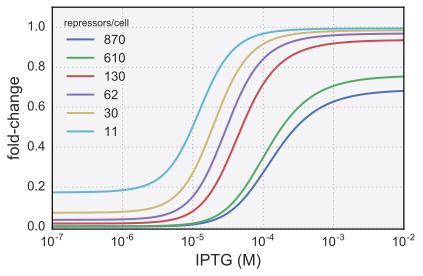

In [8]:
# Given this result let's plot all the curves using this parameters.
colors = sns.color_palette(n_colors=8)

repressor = df.repressors.unique()
plt.figure()
for i, rbs in enumerate(df.rbs.unique()):
    # plot the theory using the parameters from the fit.
    plt.plot(IPTG, mwc.fold_change_log(IPTG * 1E6, 
        ea=ea, ei=ei, epsilon=4.5,
        R=df[(df.rbs == rbs)].repressors.unique(),
        epsilon_r=-13.9),
        color=colors[i], label=repressor[i])
plt.xscale('log')
plt.xlabel('IPTG (M)')
plt.ylabel('fold-change')
plt.ylim([-0.01, 1.1])
plt.legend(loc='upper left', ncol=1, title='repressors/cell', fontsize=13)
plt.tight_layout()
plt.savefig('/Users/razo/Desktop/O2_theory.pdf')

Then let's put the data on top!

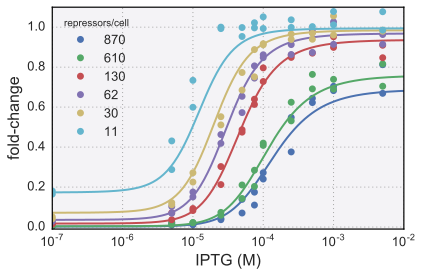

In [9]:
# Given this result let's plot all the curves using this parameters.
colors = sns.color_palette(n_colors=8)

repressor = df.repressors.unique()
plt.figure()
for i, rbs in enumerate(df.rbs.unique()):
    # plot the theory using the parameters from the fit.
    plt.plot(IPTG, mwc.fold_change_log(IPTG * 1E6, 
        ea=ea, ei=ei, epsilon=4.5,
        R=df[(df.rbs == rbs)].repressors.unique(),
        epsilon_r=-13.9),
        color=colors[i])
    # plot the experimental data
    plt.plot(df[df.rbs == rbs].sort_values(by='IPTG_uM').IPTG_uM / 1E6, 
            df[df.rbs == rbs].sort_values(by='IPTG_uM').fold_change_A, 
            marker='o', linewidth=0,
            label=repressor[i], color=colors[i], alpha=0.7)
plt.xscale('log')
plt.xlabel('IPTG (M)')
plt.ylabel('fold-change')
plt.ylim([-0.01, 1.1])
plt.legend(loc='upper left', ncol=1, title='repressors/cell', fontsize=13)
plt.tight_layout()
plt.savefig('/Users/razo/Desktop/O2_strains.pdf')

Just by eye judgement it looks really good. let's now try to compute the *Bohr parameter* for all of these strains and get some awesome data-collapse!

In [11]:
bohr_param = []
for i in range(len(df)):
    pact = mwc.pact_log(IPTG=df.iloc[i].IPTG_uM, ea=ea, ei=ei, epsilon=4.5)
    F = -np.log(2 * df.iloc[i].repressors / 4.6E6 * pact * \
            (1 + np.exp(-4.5)) * np.exp(-df.iloc[i].binding_energy))
    bohr_param.append(F)

In [12]:
df['bohr_param'] = bohr_param

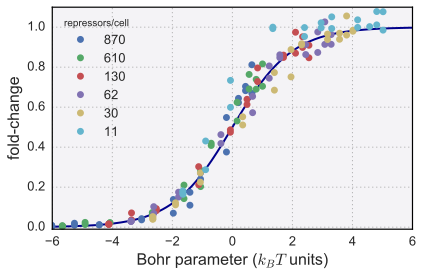

In [13]:
# Given this result let's plot all the curves using this parameters.
colors = sns.color_palette(n_colors=8)
F = np.linspace(-6, 6, 200)
repressor = df.repressors.unique()
plt.figure()
plt.plot(F, 1 / (1 + np.exp(-F)), '-', color='darkblue')
for i, rbs in enumerate(df.rbs.unique()):
    # plot the experimental data
    plt.plot(df[df.rbs == rbs].sort_values(by='IPTG_uM').bohr_param, 
            df[df.rbs == rbs].sort_values(by='IPTG_uM').fold_change_A, 
            marker='o', linewidth=0,
            label=repressor[i], color=colors[i], alpha=0.7)
plt.xlabel(r'Bohr parameter ($k_BT$ units)')
plt.ylabel('fold-change')
plt.ylim([-0.01, 1.1])
plt.xlim([-6, 6])
plt.legend(loc='upper left', ncol=1, title='repressors/cell', fontsize=13)
plt.tight_layout()
plt.savefig('/Users/razo/Desktop/data_collapse.pdf')

Voila, data collapse baby!